# Transfer Learning model demo

### Demo Description

In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
!pip install torch
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
!pip install torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import time
from tqdm import trange
from tqdm import tqdm
import torch.nn as nn
import copy
import torch.optim as optim
import pandas as pd
import os
from pathlib import Path
import operator

# Define IAM role
role = get_execution_role()
my_region = boto3.session.Session().region_name # set the region of the instance



print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the container for your SageMaker endpoint.")

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl (168.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 5.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 2.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 16.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 13.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 927.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Testing out access to an s3 bucket

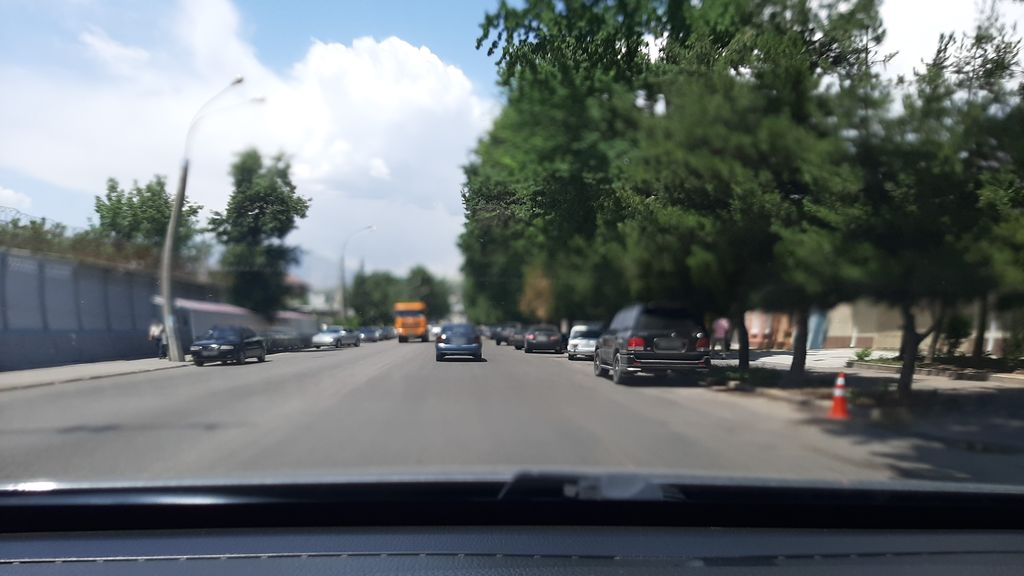

In [2]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

# open it directly
with fs.open(f's3://capgemini-cvguild/multimodalrecognition/streetlevel_images/TJ-2017-7#-00000001/1394848864223918.jpeg') as f:
    display(Image.open(f))

In [ ]:

bucket_name = 'trained_models'

s3 = boto3.resource('s3')

# check if the bucket exists
if s3.Bucket(bucket_name) in s3.buckets.all():
    print(f"{bucket_name} already exists.")
else:
    # create the bucket
    s3.create_bucket(Bucket=bucket_name)
    print(f"{bucket_name} created successfully.")

# Building a dataloader for STREET LEVEL IMAGES

In [21]:
import boto3
import os
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
import concurrent.futures

class S3ImageDataset(Dataset):
    def __init__(self, bucket_name, folder_path, class_folders=None, transform=None):
        # initialize attributes
        self.bucket_name = bucket_name
        self.folder_path = folder_path
        self.class_folders = class_folders
        self.transform = transform
        
        # create S3 resource
        self.s3 = boto3.resource('s3')
        self.bucket = self.s3.Bucket(bucket_name)
        
        # initialize lists to store image paths and labels
        self.images = []
        self.labels = []
        
        s3 = boto3.client('s3')
        
        # Make sure the prefix ends with a forward slash
        if not folder_path.endswith('/'):
            folder_path = folder_path + '/'

        # List all folders in the folder
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path, Delimiter='/')

        image_data = []

        # Loop through the folders and print their names
        for obj in tqdm(response.get('CommonPrefixes', [])):
            folder_name = obj.get('Prefix').replace(folder_path, '', 1).strip('/')
            full_path = folder_path + folder_name
            for sub_obj in s3.list_objects_v2(Bucket=bucket_name, Prefix=full_path)['Contents']:
                image_data.append((sub_obj['Key'], folder_name))

        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(self.load_image, image_data), total=len(image_data)))

        for img, label in results:
            self.images.append(img)
            self.labels.append(label)
                
    def load_image(self, img_data):
        img_obj = self.bucket.Object(img_data[0])
        img_data = img_obj.get().get('Body').read()
        img = Image.open(BytesIO(img_data))
        # apply transformation if specified
        if self.transform:
            img = self.transform(img)
        return (img, img_data[1])

    def __len__(self):
        # return the number of images in the dataset
        return len(self.images)

class S3DataLoader:
    def __init__(self, bucket_name, folder_path, batch_size=32, shuffle=True, num_workers=4, transform=None):
        # initialize the dataset and dataloader
        self.dataset = S3ImageDataset(bucket_name=bucket_name, folder_path=folder_path, class_folders=None, transform=transform)
        self.split_dataset = self.train_val_dataset(self.dataset)
        self.split_loader = {x: DataLoader(self.split_dataset[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in ['train', 'val']}
        
    def __iter__(self):
        # return the iterator over the dataloader
        return iter(self.split_loader)

    def __len__(self):
        # return the number of batches in the dataloader
        return len(self.split_loader)
    
    def train_val_dataset(self, val_split=0.3):
        # Split the indices of the dataset into train and validation sets
        train_idx, val_idx = train_test_split(list(range(len(self.dataset))), test_size=val_split)

        # Create a dictionary to store the train and validation datasets
        datasets = {}

        # Create a Subset for the train dataset using the train indices
        datasets['train'] = Subset(self.dataset, train_idx)



# Building a dataloader for SATELITTE IMAGES

In [18]:
class S3NPZDataset(Dataset):
    def __init__(self, bucket_name, folder_path, class_folders=None, transform=None):
        # initialize attributes
        self.bucket_name = bucket_name
        self.folder_path = folder_path
        self.class_folders = class_folders
        self.transform = transform
        
        # create S3 resource
        self.s3 = boto3.resource('s3')
        self.bucket = self.s3.Bucket(bucket_name)
        
        # initialize lists to store file paths and labels
        self.files = []
        self.labels = []
        
        # Make sure the prefix ends with a forward slash
        if not folder_path.endswith('/'):
            folder_path = folder_path + '/'
        
        # List all folders in the folder
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path, Delimiter='/')

        # Loop through the folders and print their names
        for obj in tqdm(response.get('CommonPrefixes', [])):
            folder_name = obj.get('Prefix').replace(folder_path, '', 1).strip('/')
            full_path = folder_path + folder_name

            # Iterate over objects in the folder
            for sub_obj in s3.list_objects_v2(Bucket=bucket_name, Prefix=full_path)['Contents']:
                if sub_obj['Key'].endswith('.npz'):
                    # Extract the file name without the file type
                    file_name_without_type = os.path.splitext(os.path.basename(sub_obj['Key']))[0]

                    # Append the file name and folder name to the lists
                    self.files.append(sub_obj['Key'])
                    self.labels.append(file_name_without_type)

        
        self.data = []
        self.targets = []
        
        # Load data from NPZ files
        for file_path in tqdm(self.files):
            obj = self.bucket.Object(file_path)
            npz_data = np.load(BytesIO(obj.get()['Body'].read()))
            data = npz_data['x']
            self.data.append(cropND(data, (np.shape(data)[0],224,224)))
                
    
    def __len__(self):
        # return the number of files in the dataset
        return len(self.files)
    
    def __getitem__(self, index):
        # return the data and label at the given index
        return self.data[index], self.targets[index]                
    
    def __len__(self):
        # return the number of images in the dataset
        return len(self.images)
    
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]


class NPZLoader(DataLoader):
    def __init__(self, path, transform):
        self.path = path
        self.files = list(Path(path).glob('*/*.npz'))
        self.transform = transform

    def __len__(self):
        return len(self.files)
    

    def __getitem__(self, item):
        numpy_array = np.load(str(self.files[item]))['x']
        torch_array = cropND(numpy_array, (np.shape(numpy_array)[0],224,224))

        return torch_array

    
class S3NPZDataLoader:
    def __init__(self, bucket_name, folder_path, batch_size=32, shuffle=True, num_workers=4, transform = None):
        # initialize the dataset and dataloader
        self.dataset = S3NPZDataset(bucket_name=bucket_name, folder_path=folder_path, class_folders=None, transform=transform)
        self.split_dataset = train_val_dataset(self.dataset)
        self.split_loader = {x: torch.utils.data.DataLoader(self.split_dataset[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'val']}
        
        #DataLoader(self.split_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        
    def __iter__(self):
        # return the iterator over the dataloader
        return iter(self.split_loader)

    def __len__(self):
        # return the number of batches in the dataloader
        return len(self.split_loader)
    
    def train_val_dataset(self, val_split=0.3):
        # Split the indices of the dataset into train and validation sets
        train_idx, val_idx = train_test_split(list(range(len(self.dataset))), test_size=val_split)

        # Create a dictionary to store the train and validation datasets
        datasets = {}

        # Create a Subset for the train dataset using the train indices
        datasets['train'] = Subset(self.dataset, train_idx)

        # Create a Subset for the validation dataset using the validation indices
        datasets['val'] = Subset(self.dataset, val_idx)

        # Return the dictionary of train and validation datasets
        return datasets


# Load data for the Street-Level Images

In [22]:
# define data transforms
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# create S3 dataloader
bucket_name = "capgemini-cvguild"
folder_path = "multimodalrecognition/streetlevel_images/"
batch_size = 32
s3dl = S3DataLoader(bucket_name, folder_path, batch_size=batch_size, shuffle=True, num_workers=4, transform = transform)
street_dataloaders_dict = s3dl.split_loader

  5%|▌         | 989/19382 [00:25<07:51, 38.99it/s]


KeyboardInterrupt: 

# Load data of the Satelitte Images

In [ ]:


#defining a built-in tranform function
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
# create S3 dataloader
bucket_name = "capgemini-cvguild"
folder_path = "multimodalrecognition/satelitte_images/"
batch_size = 32
s3dl = S3NPZDataLoader(bucket_name, folder_path, batch_size=batch_size, shuffle=True, num_workers=4, transform = transform)
sat_dataloaders_dict = s3dl.split_loader

  7%|▋         | 92/1332 [00:06<01:37, 12.66it/s]

# Load in the DHS labels

In [17]:
import boto3
import pandas as pd

# Create an S3 client
s3 = boto3.client('s3')

# Set the bucket name and file name
bucket_name = "capgemini-cvguild"
file_name =  'multimodalrecognition/population_indicators/dhs_final_labels.csv'

# Download the file from S3 to a DataFrame
obj = s3.get_object(Bucket=bucket_name, Key=file_name)
features_df = pd.read_csv(obj['Body'])
display(features_df)

# make a target dict
target_dict = {}
test_keys = list(features_df['DHSID_EA'])
test_values = list(features_df['sanitation_index'])

target_dict = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,under5_mort,n_under5_mort,women_edu,women_bmi,n_women_edu,n_women_bmi,cluster_id,adm1fips,adm1dhs,urban
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,0.0,6.0,9.500000,24.365000,18.0,18.0,1,NaN,9999,R
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,NaN,NaN,8.600000,23.104000,20.0,20.0,2,NaN,9999,R
2,AL-2008-5#-00000003,AL,2008,40.750037,19.974262,18.0,2.909049,18.0,4.500000,18.0,...,NaN,NaN,9.666667,22.387778,18.0,18.0,3,NaN,9999,R
3,AL-2008-5#-00000004,AL,2008,40.798931,19.863338,19.0,2.881122,19.0,4.947368,19.0,...,NaN,NaN,9.952381,27.084500,21.0,20.0,4,NaN,9999,R
4,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,0.0,6.0,8.937500,24.523125,16.0,16.0,5,NaN,9999,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117639,ZW-2015-7#-00000396,ZW,2015,-17.915288,31.156115,24.0,1.094416,24.0,3.875000,24.0,...,0.0,20.0,9.750000,23.163000,24.0,20.0,396,NaN,9,U
117640,ZW-2015-7#-00000397,ZW,2015,-18.379501,31.872287,25.0,0.506343,25.0,3.800000,25.0,...,0.0,24.0,8.000000,24.330455,23.0,22.0,397,NaN,1,R
117641,ZW-2015-7#-00000398,ZW,2015,-16.660612,29.850649,28.0,-1.125132,28.0,2.714286,28.0,...,0.0,26.0,7.517241,23.648846,29.0,26.0,398,NaN,4,R
117642,ZW-2015-7#-00000399,ZW,2015,-17.914251,30.956975,25.0,2.217437,25.0,3.560000,25.0,...,0.0,20.0,11.243243,26.576286,37.0,35.0,399,NaN,9,U


### Extracting the locations from the folder names

In [133]:
# Create an S3 client
s3 = boto3.client('s3')

# Set the bucket name
bucket_name = "capgemini-cvguild"
folder_path = "multimodalrecognition/streetlevel_images/"

# Make sure the prefix ends with a forward slash
if not folder_path.endswith('/'):
    folder_path = folder_path + '/'

# List all folders in the folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path, Delimiter='/')

# save street level image locations for labelling
locations = []

# Loop through the folders and print their names
for obj in response.get('CommonPrefixes', []):
    folder_name = obj.get('Prefix').replace(folder_path, '', 1).strip('/')
    locations.append(folder_name)

# Defining a Training function

In [78]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def train_model(model, dataloaders, locations, target_dict,  criterion, optimizer,num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
            # Iterate over data.
            
            print(tepoch)
            for inputs, labels in tepoch:
                # get DHSID_EA id for all labels
                lb_ids = [locations[id] for id in labels]
                # get feature values
                labels = [target_dict[lb_id] for lb_id in lb_ids]

                labels = torch.Tensor(labels)

                inputs = inputs.to(device)
                labels = labels.to(device)
                print('labels',labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):


                    outputs = model(inputs)
                    print('outputs', outputs)
                    loss = criterion(outputs, labels)
                    print('loss', loss)

                    _, preds = torch.max(outputs, 1)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                #getCategoricalAccuracy(preds, labels.data, class_dict)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
            val_acc_history.append(epoch_acc)
        if phase == 'train':
            train_acc_history.append(epoch_acc)

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

cpu


# First pass on the model - Train the model on HQ data (Satelitte data)

In [79]:
import time
import copy
criterion = nn.MSELoss()
epoch = 10 # from baseline


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

feature_extract = True


# ResNet 34
model_ft = models.resnet34(pretrained=True)
set_parameter_requires_grad(model_ft, True)
model_ft.fc = nn.Linear(512, 1)

input_size = 224
model_ft_balanced = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)

# Training a pretrained Resnet18 on a balanced dataset
model_ft, val_hist, hist  = train_model(model_ft, sat_dataloaders_dict, locations, target_dict,   criterion, optimizer_ft,num_epochs= epoch)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 114MB/s]


Params to learn:
	 fc.weight
	 fc.bias


NameError: name 'sat_dataloaders_dict' is not defined

In [ ]:
import h5py

### SAVE MODEL

# Save your PyTorch model as an HDF5 file
with h5py.File('pretrainedmodel.h5', 'w') as f:
    for k, v in model.state_dict().items():
        f.create_dataset(k, data=v.cpu().numpy())

# Upload your HDF5 file to an S3 bucket
s3 = boto3.client('s3')
bucket_name = 'trained_models'
s3.upload_file('pretrainedmodel.h5', bucket_name, 'pretrainedmodel.h5')


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False    

### LOAD MODEL

# Define S3 client and bucket name
s3 = boto3.client('s3')
bucket_name = 'trained_models'

# Define path to model file in S3 bucket
model_file_path = 'satmodel.h5'

# Download and load PyTorch model from S3 bucket
def load_model_from_s3():
    # Download model file from S3 bucket
    model_file = BytesIO()
    s3.download_fileobj(bucket_name, model_file_path, model_file)
    model_file.seek(0)

    # Load model from HDF5 file
    model = models.resnet34()
    with h5py.File(model_file, 'r') as f:
        for k, v in f.items():
            model_state = torch.load(BytesIO(v[()]), map_location=torch.device('cpu'))
            set_parameter_requires_grad(model, True)
            model.load_state_dict(model_state)

    return model

# Load PyTorch model from S3 bucket
model = load_model_from_s3()

# Step 2 - Fine tune the model on LQ data (Street-level data)

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Training a pretrained Resnet18 on a balanced dataset
model_finetuned, val_hist, hist  = train_model(model, street_dataloaders_dict, locations, target_dict,   criterion, optimizer_ft,num_epochs= epoch)

In [ ]:

# Save your PyTorch model as an HDF5 file
with h5py.File('finetunedmodel.h5', 'w') as f:
    for k, v in model.state_dict().items():
        f.create_dataset(k, data=v.cpu().numpy())

# Upload your HDF5 file to an S3 bucket
s3 = boto3.client('s3')
bucket_name = 'trained_models'
s3.upload_file('finetunedmodel.h5', bucket_name, 'finetunedmodel.h5')